<a href="https://colab.research.google.com/github/leminhviett/Who-would-win-the-Olympics/blob/master/Who_would_win.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd 
import numpy as np

import xgboost
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.utils import class_weight



sb.set()
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
import warnings
warnings.filterwarnings('ignore')

# Le Minh Viet part


1.   Data exploration & Data understading
2.   Data pre-process:

        * Encoding categorical data
        
        * Clean & clear data
3.   Machine Learning:
        * Try different machine learning models
        * Visualize results of each model on imbalanced & balanced dataset
        * Find out the best model for individual sport




## 1. Import data


In [0]:
athlete = pd.read_csv("/content/drive/My Drive/data/athlete_events.csv")
regions = pd.read_csv("/content/drive/My Drive/data/noc_regions.csv")
raw_data = pd.merge(athlete, regions, on='NOC', how='left')

In [0]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271116 entries, 0 to 271115
Data columns (total 17 columns):
ID        271116 non-null int64
Name      271116 non-null object
Sex       271116 non-null object
Age       261642 non-null float64
Height    210945 non-null float64
Weight    208241 non-null float64
Team      271116 non-null object
NOC       271116 non-null object
Games     271116 non-null object
Year      271116 non-null int64
Season    271116 non-null object
City      271116 non-null object
Sport     271116 non-null object
Event     271116 non-null object
Medal     39783 non-null object
region    270746 non-null object
notes     5039 non-null object
dtypes: float64(3), int64(2), object(12)
memory usage: 37.2+ MB


In [0]:
raw_data.head(5)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,notes
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN,China,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN,China,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN,Denmark,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark,NaN
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN,Netherlands,NaN


In [0]:
raw_data.describe()

,ID,Age,Height,Weight,Year
count,271116.000000,261642.000000,210945.000000,208241.000000,271116.000000
mean,68248.954396,25.556898,175.338970,70.702393,1978.378480
std,39022.286345,6.393561,10.518462,14.348020,29.877632
min,1.000000,10.000000,127.000000,25.000000,1896.000000
25%,34643.000000,21.000000,168.000000,60.000000,1960.000000
50%,68205.000000,24.000000,175.000000,70.000000,1988.000000
75%,102097.250000,28.000000,183.000000,79.000000,2002.000000
max,135571.000000,97.000000,226.000000,214.000000,2016.000000


## 2. Pre-process Data



1.   Replace NA of Height, Age, Weight by its Median
2.   Encode all sports as 0,1,2,3...
3.   Encode Gold, Silver, Bronze, NA as 3, 2, 1,
4.   Encode Sex & Season as 0, 1
5.   Region we have to use special function to encode.

     **Point of each region = (#gold * 3 + #silver * 2 + #bronze) / (sum of all Medal)**

     This point reflects of competency of each region in the past




In [0]:
pre_process = raw_data.copy()
pre_process = pd.DataFrame(pre_process[["Sex", "Age", "Height", "Weight", "Season", "Sport", "Medal", "Year","region"]])


In [0]:
imputer = Imputer(strategy="median")
imputer.fit(pd.DataFrame(pre_process[["Age", "Height", "Weight"]])) # calculate median of all attributes
median = imputer.statistics_# store into statistics_; may be we use latter

temp = imputer.transform(pd.DataFrame(pre_process[["Age", "Height", "Weight"]]))
pre_process[["Age", "Height", "Weight"]] = pd.DataFrame(temp)

sport = LabelEncoder()
season = LabelEncoder()
pre_process['Sport'] = sport.fit_transform(pre_process['Sport'])
pre_process['Season'] = season.fit_transform(pre_process['Season'])

pre_process["Medal"].fillna(0, inplace = True)
pre_process = pre_process.replace(to_replace = ["Gold", "Silver", "Bronze", "M", "F"],value = [3,2,1, 1, 0])


In [0]:
pre_process.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271116 entries, 0 to 271115
Data columns (total 9 columns):
Sex       271116 non-null int64
Age       271116 non-null float64
Height    271116 non-null float64
Weight    271116 non-null float64
Season    271116 non-null int64
Sport     271116 non-null int64
Medal     271116 non-null int64
Year      271116 non-null int64
region    270746 non-null object
dtypes: float64(3), int64(5), object(1)
memory usage: 20.7+ MB


In [0]:
competency = pd.DataFrame(pre_process.loc[pre_process["Year"] <= 2006]) # use only data be4 2005 to get the competency point. its 70% data

for i in pre_process.region.unique():
  country = competency.loc[competency["region"] == i]
  g = country.loc[country["Medal"] == 3]
  s = country.loc[country["Medal"] == 2]
  b = country.loc[country["Medal"] == 1]
  na = country.loc[country["Medal"] == 0]

  point = g.shape[0]*30 + s.shape[0]*20 + b.shape[0]*10
  try:
    point = point/(g.shape[0] + s.shape[0] + b.shape[0] + na.shape[0])
  except ZeroDivisionError:
    pre_process.loc[pre_process['region'] == i, 'region_point'] = 0
    continue
  pre_process.loc[pre_process['region'] == i, 'region_point'] = point


In [0]:
pre_process.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271116 entries, 0 to 271115
Data columns (total 10 columns):
Sex             271116 non-null int64
Age             271116 non-null float64
Height          271116 non-null float64
Weight          271116 non-null float64
Season          271116 non-null int64
Sport           271116 non-null int64
Medal           271116 non-null int64
Year            271116 non-null int64
region          270746 non-null object
region_point    270746 non-null float64
dtypes: float64(4), int64(5), object(1)
memory usage: 22.8+ MB


In [0]:
pre_process = pre_process.dropna()

In [0]:
pre_process.head(5)

,Sex,Age,Height,Weight,Season,Sport,Medal,Year,region,region_point
0,1,24.0,180.0,80.0,0,8,0,1992,China,2.906946
1,1,23.0,170.0,60.0,0,32,0,2012,China,2.906946
2,1,24.0,175.0,70.0,0,24,0,1920,Denmark,3.352490
3,1,34.0,175.0,70.0,0,61,3,1900,Denmark,3.352490
4,0,21.0,185.0,82.0,1,53,0,1988,Netherlands,3.056814


In [0]:
pre_process.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 270746 entries, 0 to 271115
Data columns (total 10 columns):
Sex             270746 non-null int64
Age             270746 non-null float64
Height          270746 non-null float64
Weight          270746 non-null float64
Season          270746 non-null int64
Sport           270746 non-null int64
Medal           270746 non-null int64
Year            270746 non-null int64
region          270746 non-null object
region_point    270746 non-null float64
dtypes: float64(4), int64(5), object(1)
memory usage: 22.7+ MB


In [0]:
pre_process.head(5)

,Sex,Age,Height,Weight,Season,Sport,Medal,Year,region,region_point
0,1,24.0,180.0,80.0,0,8,0,1992,China,2.906946
1,1,23.0,170.0,60.0,0,32,0,2012,China,2.906946
2,1,24.0,175.0,70.0,0,24,0,1920,Denmark,3.352490
3,1,34.0,175.0,70.0,0,61,3,1900,Denmark,3.352490
4,0,21.0,185.0,82.0,1,53,0,1988,Netherlands,3.056814


In [0]:
pre_process.describe()

,Sex,Age,Height,Weight,Season,Sport,Medal,Year,region_point
count,270746.000000,270746.000000,270746.000000,270746.000000,270746.000000,270746.000000,270746.000000,270746.000000,270746.000000
mean,0.725255,25.505496,175.268244,70.545522,0.179371,28.628626,0.294106,1978.360279,2.903855
std,0.446386,6.286433,9.280213,12.580287,0.383663,19.397892,0.775102,29.883741,1.891648
min,0.000000,10.000000,127.000000,25.000000,0.000000,0.000000,0.000000,1896.000000,0.000000
25%,0.000000,22.000000,170.000000,63.000000,0.000000,12.000000,0.000000,1960.000000,1.678832
50%,1.000000,24.000000,175.000000,70.000000,0.000000,27.000000,0.000000,1988.000000,2.654867
75%,1.000000,28.000000,180.000000,75.000000,0.000000,47.000000,0.000000,2002.000000,3.645428
max,1.000000,97.000000,226.000000,214.000000,1.000000,65.000000,3.000000,2016.000000,7.698054


**Explain why use only data before 2005 to get the point for region encode**

Data of Year before 2005 is approximately 80% of total. 20% is after 2005. We will not touch these labels because we will use them for test data.

Some countries paricipate after 2005. We will consider their competency points as 0.


## 3. Data Exploration

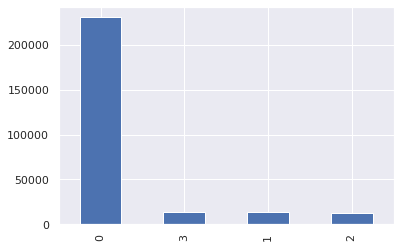

In [0]:
pd.value_counts(pre_process['Medal']).plot.bar() # imbalanced data sets

**Data set is highly imbalanced**

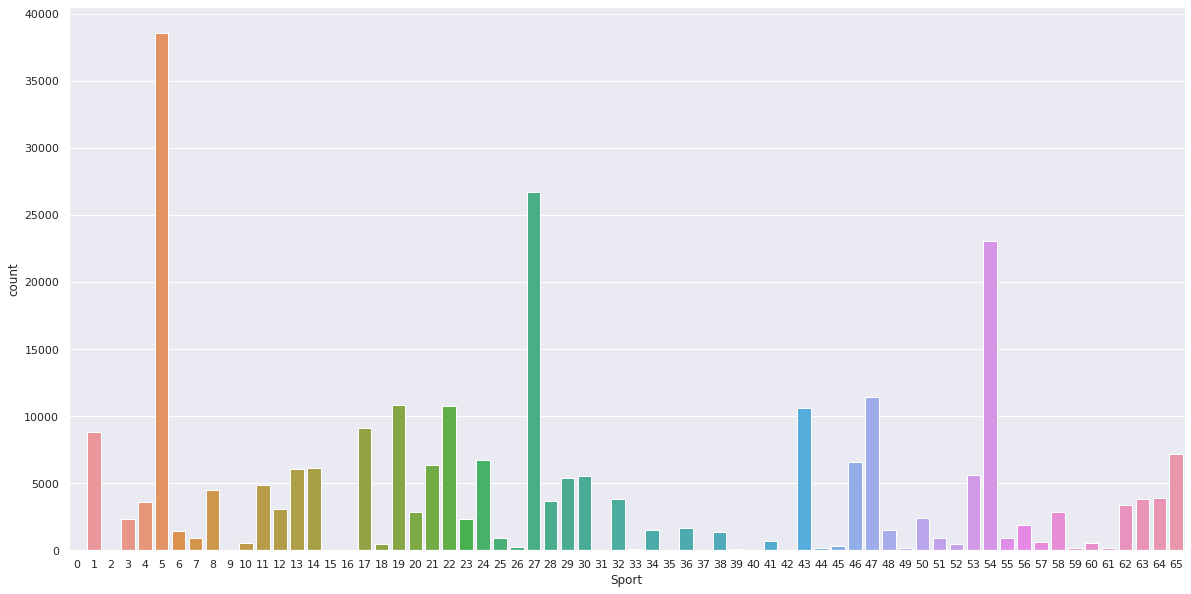

In [0]:
dims = (20, 10)
fig, ax = plt.subplots(figsize=dims)
sb.countplot(x = "Sport", data = pre_process)

**Some sports will not have enough data to train**

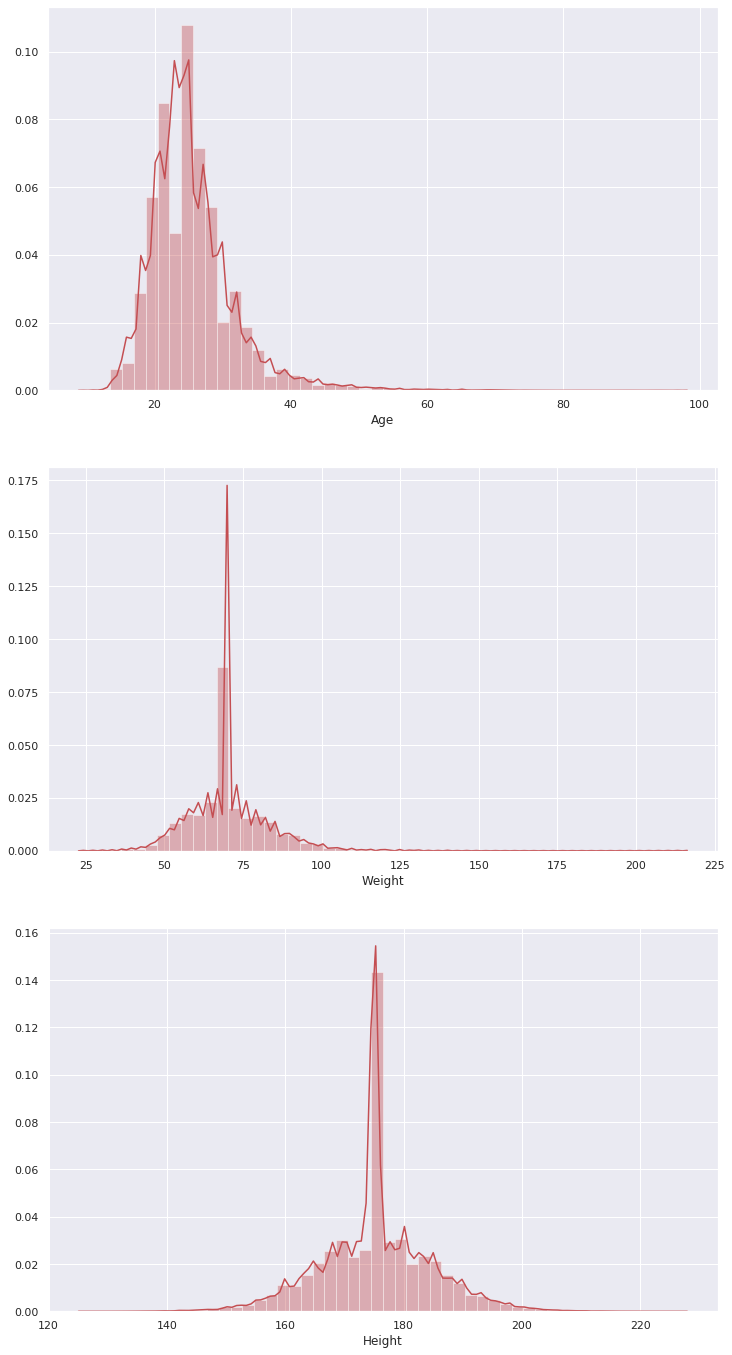

In [0]:
numeric = pd.DataFrame(pre_process[["Age", "Weight", "Height"]])
arr = ["Age", "Weight", "Height"]
f, axes = plt.subplots(3,1, figsize = (12,24))
count = 0
for i in numeric:
  sb.distplot(numeric[i],color = 'r',ax = axes[count])
  count += 1

**Distribution of Height, Age, Weight have its own meaning in sport**

[0.25318718 0.23037849 0.28312763 0.22197856 0.01132814 0.        ]


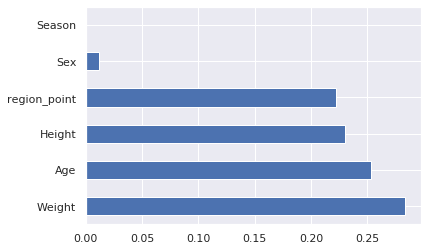

['Athletics']


In [0]:
y = pre_process.loc[pre_process["Sport"] == 5, "Medal"]
X = pre_process.loc[pre_process["Sport"] == 5, ["Age", "Height", "Weight", "region_point", "Sex", "Season"]]

model = RandomForestClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

print(sport.inverse_transform([5]))

**Try with the sport having index 5, which have the most number of data.**

We can see that season & Sex do not contribute so much to predict the Medal

## 4. Machine Learning

In [0]:
state = 42
def score_evaluate(y_test, y_pred):
  recall = recall_score(y_test, y_pred, average=None)
  precision = precision_score(y_test, y_pred, average=None)
  acc = accuracy_score(y_test, y_pred)

  print("recall:", end="\t\t ")
  for i in range(len(recall)):
    print(str(i) + ": " + "%.2f"%recall[i], end="| ")
  print("")
  print("precision:", end="\t ")  
  for i in range(len(precision)):
    print(str(i) + ": " + "%.2f"%precision[i], end="| ")
  print("")
  print("Accuracy is "+ str(acc))

  cm = confusion_matrix(y_test, y_pred)
  print(cm)
  print("")


### 4.1 Why imbalance data is not good ?

We will evaluate on dataset of 'Athlete' sport, which have the largest number of players.

Models try on:


*   RandomForestClassifier
*   XGBoost Classifier
*   GaussianNB




In [0]:
#try in a random sport
data = pd.DataFrame(pre_process.loc[pre_process["Sport"] == 46])
data.head()

,Sex,Age,Height,Weight,Season,Sport,Medal,Year,region,region_point
32,0,30.0,159.0,55.5,0,46,0,1996,Finland,2.934783
33,0,34.0,159.0,55.5,0,46,0,2000,Finland,2.934783
89,1,43.0,170.0,77.0,0,46,0,1968,Norway,4.327214
90,1,47.0,170.0,77.0,0,46,0,1972,Norway,4.327214
96,1,24.0,187.0,76.0,0,46,0,1992,Finland,2.934783


In [0]:
train = pd.DataFrame(data.loc[data["Year"] <= 2005])
test = pd.DataFrame(data.loc[data["Year"] > 2005])

X_train, y_train = train[["Age", "Height", "Weight", "region_point"]], train[["Medal"]]
X_test, y_test = test[["Age", "Height", "Weight", "region_point"]], test[["Medal"]]

In [0]:
model0 = RandomForestClassifier(random_state = state)
model0.fit(X_train, y_train)
score_evaluate(y_test, model0.predict(X_test))

recall:		 0: 0.97| 1: 0.02| 2: 0.02| 3: 0.04| 
precision:	 0: 0.88| 1: 0.07| 2: 0.10| 3: 0.12| 
Accuracy is 0.8518843120070114
[[968   8   7  11]
 [ 45   1   2   1]
 [ 43   3   1   2]
 [ 45   2   0   2]]



In [0]:
model1 = xgboost.XGBClassifier(n_jobs = -1, random_state=state, learning_rate=0.001, objective='multi:softmax')
model1.fit(X_train, y_train)
score_evaluate(y_test, model1.predict(X_test))

recall:		 0: 1.00| 1: 0.00| 2: 0.00| 3: 0.00| 
precision:	 0: 0.87| 1: 0.00| 2: 0.00| 3: 0.00| 
Accuracy is 0.8711656441717791
[[994   0   0   0]
 [ 49   0   0   0]
 [ 49   0   0   0]
 [ 49   0   0   0]]



In [0]:
#this model is based on priors prob we give;not on  distribution of data
model2 = GaussianNB(priors=[0.25, 0.25,0.25,0.25]) 
model2.fit(X_train, y_train)
score_evaluate(y_test, model2.predict(X_test))

recall:		 0: 0.67| 1: 0.04| 2: 0.02| 3: 0.22| 
precision:	 0: 0.88| 1: 0.02| 2: 0.01| 3: 0.05| 
Accuracy is 0.5968448729184925
[[667  91  68 168]
 [ 34   2   4   9]
 [ 28   6   1  14]
 [ 25   8   5  11]]



**As we can see, Imbalanced data set performs badly on both 3 model**

It gives high accuracy but low precision and recall in the minority class.

### 4.2 Fixed Imbalanced Data Set


**4 ways to cope with**
1. Oversample:  copy the given minority data
2. Undersample: remove the given majority data
3. SMOTE:       resample new data based on the given.
4. Add weight to the given function

*We only try the 3rd and 4th*

*Our data is not so many to try the 2nd one.*

*3rd Method is better than the 1st one*


In [0]:
train = pd.DataFrame(data.loc[data["Year"] <= 2005])
test = pd.DataFrame(data.loc[data["Year"] > 2005])

X_train, y_train = train[["Age", "Height", "Weight", "region_point"]], train["Medal"]
X_test, y_test = test[["Age", "Height", "Weight", "region_point"]], test["Medal"]

#### Add weight method

In [0]:
def add_w(y):
  class_w = class_weight.compute_class_weight('balanced', np.unique(y), y)
  dict_weight = {}
  x = list(y.unique())
  x.sort()
  j = 0
  # get the balanced dict weight
  while(j < len(class_w)):
    dict_weight.update({x[j] : class_w[j]})
    j += 1
  print("class_weight = ", dict_weight)
  return dict_weight


In [0]:
model0 = RandomForestClassifier(random_state = state,  class_weight = add_w(y_train))
model0.fit(X_train, y_train)
score_evaluate(y_test, model0.predict(X_test))

class_weight =  {0: 0.3127748206433696, 1: 4.25, 2: 3.692622950819672, 3: 3.3703241895261846}
recall:		 0: 0.97| 1: 0.00| 2: 0.00| 3: 0.02| 
precision:	 0: 0.87| 1: 0.00| 2: 0.00| 3: 0.10| 
Accuracy is 0.8492550394390885
[[968   9   9   8]
 [ 49   0   0   0]
 [ 46   2   0   1]
 [ 46   2   0   1]]



#### SMOTE

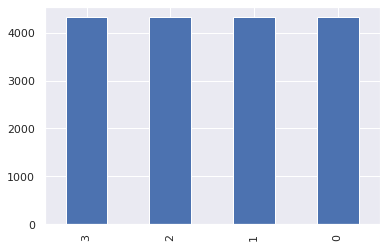

In [0]:
sm = SMOTE('auto', random_state=state)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)
pd.value_counts(y_train_sm).plot.bar() # imbalanced data sets

In [0]:
model0 = RandomForestClassifier(random_state = state)
model0.fit(X_train_sm, y_train_sm)
score_evaluate(y_test, model0.predict(X_test))

recall:		 0: 0.86| 1: 0.04| 2: 0.04| 3: 0.06| 
precision:	 0: 0.87| 1: 0.03| 2: 0.04| 3: 0.07| 
Accuracy is 0.7537248028045574
[[853  61  42  38]
 [ 44   2   2   1]
 [ 38   5   2   4]
 [ 42   3   1   3]]



In [0]:
model2 = xgboost.XGBClassifier(n_jobs = -1, random_state=state, learning_rate=0.01, objective='multi:softmax')
model2.fit(X_train_sm, y_train_sm)
X_test_sm = X_test.rename(columns={"Age": "f0", "Height": "f1", "Weight":"f2","region_point":"f3"})
y_pred= model2.predict(X_test_sm)
score_evaluate(y_test, y_pred)

recall:		 0: 0.62| 1: 0.33| 2: 0.04| 3: 0.14| 
precision:	 0: 0.89| 1: 0.06| 2: 0.02| 3: 0.09| 
Accuracy is 0.5600350569675723
[[614 241  75  64]
 [ 28  16   2   3]
 [ 26  14   2   7]
 [ 22  17   3   7]]



**As we can see using SMOTE & adding weight give better precision & recall compared to imbalanced data**


### 4.3 Apply SMOTE or adding weight & Random Forest for final model.

We design a model to predict medals of **basketball players**

In [0]:
# we ll try on basketball sport
basketball_data = pd.DataFrame(pre_process.loc[pre_process["Sport"] == 8])
basketball_data.head()

,Sex,Age,Height,Weight,Season,Sport,Medal,Year,region,region_point
0,1,24.0,180.0,80.0,0,8,0,1992,China,2.906946
167,0,19.0,185.0,72.0,0,8,0,2008,Spain,1.513630
250,1,31.0,175.0,70.0,0,8,0,1952,Egypt,0.331447
264,1,29.0,195.0,85.0,0,8,0,2000,Italy,3.287611
346,1,25.0,189.0,85.0,0,8,0,1972,Egypt,0.331447


recall:		 0: 0.76| 1: 0.19| 2: 0.19| 3: 0.92| 
precision:	 0: 0.85| 1: 0.17| 2: 0.16| 3: 0.59| 
Accuracy is 0.6748538011695906
[[483  63  64  29]
 [ 32  14  10  16]
 [ 56   1  14   1]
 [  0   5   1  66]]



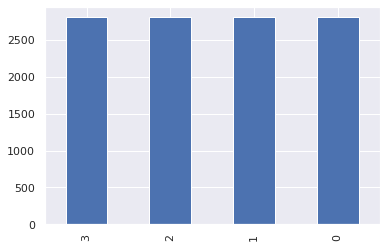

In [0]:
train = pd.DataFrame(basketball_data.loc[basketball_data["Year"] <= 2005])
test = pd.DataFrame(basketball_data.loc[basketball_data["Year"] > 2005])

X_train, y_train = train[["Age", "Height", "Weight", "region_point"]], train["Medal"]
X_test, y_test = test[["Age", "Height", "Weight", "region_point"]], test["Medal"]

sm = SMOTE('auto', random_state=state)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)
pd.value_counts(y_train_sm).plot.bar() # imbalanced data sets

model0 = RandomForestClassifier(random_state = state)
model0.fit(X_train_sm, y_train_sm)
score_evaluate(y_test, model0.predict(X_test))

In [0]:
model0 = RandomForestClassifier(random_state = state, class_weight=add_w(y_train))
model0.fit(X_train, y_train)
score_evaluate(y_test, model0.predict(X_test))

class_weight =  {0: 0.3269504809405059, 1: 3.2315140845070425, 2: 3.197735191637631, 3: 3.1322525597269624}
recall:		 0: 0.90| 1: 0.19| 2: 0.10| 3: 0.94| 
precision:	 0: 0.84| 1: 0.24| 2: 0.28| 3: 0.79| 
Accuracy is 0.775438596491228
[[574  40  12  13]
 [ 47  14   6   5]
 [ 64   1   7   0]
 [  0   4   0  68]]



##### In this case, adding weight performs better than SMOTE in overall. We use adding weight as the final model for basketball.

From this point forward, we use the **whole data set** to get the 'region_point' column.

In [0]:
data = pre_process.copy()

for i in pre_process.region.unique():
  country = pre_process.loc[pre_process["region"] == i]
  g = country.loc[country["Medal"] == 3]
  s = country.loc[country["Medal"] == 2]
  b = country.loc[country["Medal"] == 1]
  na = country.loc[country["Medal"] == 0]

  point = g.shape[0]*30 + s.shape[0]*20 + b.shape[0]*10
  try:
    point = point/(g.shape[0] + s.shape[0] + b.shape[0] + na.shape[0])
  except ZeroDivisionError:
    data.loc[data['region'] == i, 'region_point'] = 0
    continue
  data.loc[data['region'] == i, 'region_point'] = point
data.head(3) #region_point of whole data set

,Sex,Age,Height,Weight,Season,Sport,Medal,Year,region,region_point
0,1,24.0,180.0,80.0,0,8,0,1992,China,3.508411
1,1,23.0,170.0,60.0,0,32,0,2012,China,3.508411
2,1,24.0,175.0,70.0,0,24,0,1920,Denmark,3.350140


In [0]:
pre_process.head(3) #region_point only using data before 2005

,Sex,Age,Height,Weight,Season,Sport,Medal,Year,region,region_point
0,1,24.0,180.0,80.0,0,8,0,1992,China,2.906946
1,1,23.0,170.0,60.0,0,32,0,2012,China,2.906946
2,1,24.0,175.0,70.0,0,24,0,1920,Denmark,3.352490


In [0]:
basketball_data = data.loc[data["Sport"] == 8]
X, y = basketball_data[["Age", "Height", "Weight", "region_point"]], basketball_data["Medal"]
model0 = RandomForestClassifier(random_state = state, class_weight=add_w(y))
model0.fit(X, y)
basketball_data.head()

class_weight =  {0: 0.3283517121300058, 1: 3.178370786516854, 2: 3.151810584958217, 3: 3.1}


,Sex,Age,Height,Weight,Season,Sport,Medal,Year,region,region_point
0,1,24.0,180.0,80.0,0,8,0,1992,China,3.508411
167,0,19.0,185.0,72.0,0,8,0,2008,Spain,1.791831
250,1,31.0,175.0,70.0,0,8,0,1952,Egypt,0.302096
264,1,29.0,195.0,85.0,0,8,0,2000,Italy,3.096594
346,1,25.0,189.0,85.0,0,8,0,1972,Egypt,0.302096


In [0]:
#[age, weight, height, region_point]
athlet_characteristics = [[22, 180, 90, 10],[32, 180, 150, 7.5],[20, 200, 120, 8],[30, 195, 100.5, 6], [24, 185, 80, 7.5]] 
model0.predict(athlet_characteristics)

array([2, 0, 3, 3, 1])

In [0]:
def print_out(inp, outp):
  count = 0
  for i in outp:
    print("Age %d | Height %4.1f (m)| Weight %.1f (kg) | Region_encode %.2f \t |"% (inp[count][0],inp[count][1], inp[count][2], inp[count][3]), end="\t ")
    if(i == 0):
      print("No medal")
    elif(i == 1):
      print("Bronze")
    elif(i == 2):
      print("Silver")
    elif(i == 3):
      print("Gold")
    count += 1


In [0]:
print("Basketball Medal Prediction: \n")
print_out(athlet_characteristics, model0.predict(athlet_characteristics))

Basketball Medal Prediction: 

Age 22 | Height 180.0 (m)| Weight 90.0 (kg) | Region_encode 10.00 	 |	 Silver
Age 32 | Height 180.0 (m)| Weight 150.0 (kg) | Region_encode 7.50 	 |	 No medal
Age 20 | Height 200.0 (m)| Weight 120.0 (kg) | Region_encode 8.00 	 |	 Gold
Age 30 | Height 195.0 (m)| Weight 100.5 (kg) | Region_encode 6.00 	 |	 Gold
Age 24 | Height 185.0 (m)| Weight 80.0 (kg) | Region_encode 7.50 	 |	 Bronze


For other different sports, we have to train them individually & observe which model & technique giving the best result. 

**Different data set has different best way to solve**